# Technical Test for Data Scientist position in Opportunity Network
⌨️***March 2023***

## Instructions
- Perform any analysis you think should be applied and write down any question you think the dataset can answer
- The document has several cells to define the basic sections of the task that we want you to complete
- Comment your code.

## Table of Contents
* [Data Cleaning](#first-bullet)
    * [Type Casts and General Feature Engineering](#second-bullet)
    * [Adding a language label using a Natural Language Processing model](#third-bullet)
    * [Further exploring, looking for duplicates](#fourth-bullet)
* [Data Analysis](#fifth-bullet)
    * [Date vs DayId](#sixth-bullet)
    * [Popular News Sources by country and language](#seventh-bullet)
    * [Traffic on Weekdays and Weekends](#eighth-bullet)
* [Data Analysis Using NLP](#ninth-bullet)
    * [Keywords and Traffic](#tenth-bullet)
    * [Wordcloud](#eleventh-bullet)
    * [Bi-grams Extraction with CountVectorizer](#twelfth-bullet)
    * [Top Keywords in terms of traffic vs in terms of frequency](#thirteenth-bullet)
    * [Keywords Extraction with TF IDF](#fourteenth-bullet)
    * [Results of TF IDF, ideas on alternatives](#fifteenth-bullet)
* [Clustering](#sixteenth-bullet)
* [Further ideas on models](#seventeenth-bullet)

## Data Cleaning <a class="anchor" id="first-bullet"></a>
Clean the data to extract significant statistics and possibly create a model to identify key information.

In [1]:
#import the necessary libraries
import numpy as np
import pandas as pd
#for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from matplotlib.ticker import StrMethodFormatter
#for language detection
from langdetect import detect
from langdetect import DetectorFactory
#for NLP and ML
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
#import module for Term Frequency Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import re
from nltk.corpus import stopwords
#for WordCloud
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
pd.options.mode.chained_assignment = None

In [2]:
#create a dataframe reading from the given csv file
df = pd.read_csv('./data/data_analyst_task_dataset.csv')

**First of all, let's check the dataset's, dimensions, structure and presence of null values.**

In [3]:
#check dimensions of the dataset
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 75781 rows and 13 columns.


In [4]:
#check the first 3 lines
df.head(3)

,dayId,country,type,title,date,name,traffic,publishDate,relatedKeyword,newsTitle,newsSource,newsSnippet,newsLink
0,20161128,Argentina,Top Keywords,Top Keywords Argentina 20161128,2016-11-28,Agustin Pappa,"2,000+","Mon, 28 Nov 2016 20:00:00 -0300",NaN,"Así le robaron a Agustín Pappa, el ex particip...",Online-911 (Comunicado de prensa),"La víctima del robo fue Agustín Pappa (20), un...",http://www.online-911.com/2016/11/robaron-agus...
1,20161128,Argentina,Top Keywords,Top Keywords Argentina 20161128,2016-11-28,Feriado 28 Noviembre,"20,000+","Mon, 28 Nov 2016 02:00:00 -0300",Porque Es Feriado El 28 De Noviembre,¿Por qué este lunes se celebra el Día de la So...,Minutouno.com,La conmemoración fue propuesta por el historia...,http://www.minutouno.com/notas/1523245-por-que...
2,20161128,Argentina,Top Keywords,Top Keywords Argentina 20161128,2016-11-28,Gisela Berger,"10,000+","Mon, 28 Nov 2016 13:00:00 -0300",NaN,"Quién es Gisela Berger, la sensual rubia que b...",TN.com.ar,"Daniel Scioli apareció en Punta Cana, bailando...",http://tn.com.ar/show/basicas/quien-es-gisela-...


*Are there any null values?*

In [5]:
#check if there are any null values
df.isna().sum()

dayId                 0
country               0
type                  0
title                 0
date                  0
name                  0
traffic               0
publishDate           0
relatedKeyword    58104
newsTitle          1556
newsSource         1556
newsSnippet        1559
newsLink           1556
dtype: int64

In [6]:
print(f'Percentage of nulls in "relatedKeyword": {round((58104/75781)*100,2)}%')
print(f'Percentage of nulls in "newsSource": {round((1556/75781)*100,2)}%')
print(f'Percentage of nulls in "newsSnippet": {round((1556/75781)*100,2)}%')
print(f'Percentage of nulls in "newsLink": {round((1556/75781)*100,2)}%')

Percentage of nulls in "relatedKeyword": 76.67%
Percentage of nulls in "newsSource": 2.05%
Percentage of nulls in "newsSnippet": 2.05%
Percentage of nulls in "newsLink": 2.05%


**There are some null values in the "newsTitle", "newsSource", "newsSnippet", and "NewsLink" columns, but their percentage is minimal. We could drop these without losing a significant part of the data. Meanwhile, the proportion of null values in "relatedKeyword" is high and constitutes 76.67%.**

In [7]:
#drop observations that have nulls in "newsTitle" or "newsSnippet" columns
df.drop(df[(df['newsTitle'].isna()) | (df['newsSnippet'].isna())].index, inplace=True)
#check if there are any null values left except for those in the "relatedKeyword" column
df.isna().sum()

dayId                 0
country               0
type                  0
title                 0
date                  0
name                  0
traffic               0
publishDate           0
relatedKeyword    56865
newsTitle             0
newsSource            0
newsSnippet           0
newsLink              0
dtype: int64

## Type Casts and General Feature Engineering <a class="anchor" id="second-bullet"></a>

*Let's have a closer look at the column's data types, and create new features that will be easier to use for analysis.*

In [8]:
#check column names and their datatypes
column_names = df.columns
column_dtypes = df.dtypes
for i in range(len(df.columns)):
    print(f'The column "{column_names[i]}" is of type {column_dtypes[i]}.')

The column "dayId" is of type int64.
The column "country" is of type object.
The column "type" is of type object.
The column "title" is of type object.
The column "date" is of type object.
The column "name" is of type object.
The column "traffic" is of type object.
The column "publishDate" is of type object.
The column "relatedKeyword" is of type object.
The column "newsTitle" is of type object.
The column "newsSource" is of type object.
The column "newsSnippet" is of type object.
The column "newsLink" is of type object.


**Almost all columns are of type string. However, some of these columns would be easier to use as date (e.g. the date per se, the year, the month and the day of week), or as a numeric data type in case of traffic.**

In [9]:
#convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [10]:
#extract year
df['year'] = df['date'].dt.year

In [11]:
#extract month of year
df['month_of_year'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))

*The day of the week when the piece is published might be interesting for analysis. We can retrieve this information from "publishDate" column.*

In [12]:
#extract day of week from "publishDate" field
df['publishDOW'] = df['publishDate'].str.split(',').str[0]

In [13]:
#check unique values of the new column
df['publishDOW'].unique()

array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], dtype=object)

**However, the informative part of the day of week is not the exact day of week, but whether it is weekend or not. I will proceed to create a new category with values *Weekday* and *Weekend* based on the day of week values extracted in the previous step.**

In [14]:
df.loc[df['publishDOW'].isin(['Mon', 'Tue', 'Wed', 'Thu', 'Fri']), 'publishDOW'] = 'Weekday'
df.loc[df['publishDOW'].isin(['Sat', 'Sun']), 'publishDOW'] = 'Weekend'

In [15]:
df['publishDOW'].unique()

array(['Weekday', 'Weekend'], dtype=object)

**Another feature that can be useful in this analysis is a numeric value of *traffic*.**

In [16]:
#create new column with numeric value of traffic
df['traffic_int'] = 0
for lab, row in df.iterrows():
    df.loc[lab, 'traffic_int'] = int(''.join(df.loc[lab, 'traffic'].strip('+').split(',')))

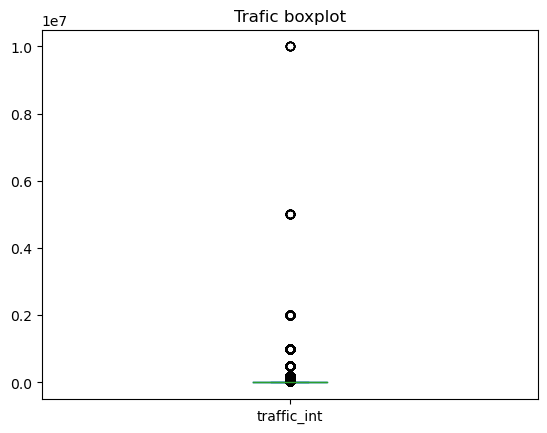

In [17]:
#check the distribution of traffic
df.traffic_int.plot.box()
plt.title('Trafic boxplot')
plt.show()

Technically, there are a some outliers, but given the uneven popularity of different media, this seems plausible.

### Adding a language label using a Natural Language Processing model <a class="anchor" id="third-bullet"></a>

Another important aspect of this dataset is presence of different languages. One might be tempted to add a column language based on the country, but as we have seen in the "country" field, there are some countries -e.g. Belgium, Canada, Spain, Switzerland, etc.- that have multiple official languages.

**One way to solve this issue would be to use the langdetect language-detection library to create a new "language" column.**
It is important to keep in mind that there are some null values in the "newsSnippet" column and that this language detection algorithm is non-deterministic and gives better probabilities with larger input. So, I will create a new text column combining both "newsTitle" and "newsSnippet" in order to obtain better language-detection results. Given that some of these will be null, and concatenating with a null value gives null as a result, I will first impute them with an empty string. Besides, to enforce consistent results, I will set the pseudo-random seed.

In [18]:
#set seed
DetectorFactory.seed = 0

In [149]:
#create a new column with all the article-related text available
df['all_text'] = df['newsTitle'].fillna('') + ' ' + df['newsSnippet'].fillna('')
#detele the extra spaces at the end of each text
df['all_text'] = df['all_text'].str.strip()
#check for null values
print(f'Are there any null values? Answer: {df["all_text"].isna().any()}')

Are there any null values? Answer: False


In [20]:
#check summary statistics for the lengths of the resulting text in characters
df['all_text'].apply(len).quantile([0, 0.05, 0.25, 0.5, 0.75, 1])

0.00    94.00
0.05   159.00
0.25   293.00
0.50   310.00
0.75   323.00
1.00   897.00
Name: all_text, dtype: float64

*All texts are relatively long ranging from 94 to 897 characters. This isn't extremely long to give reliable result for text analysis, but should be enough to detect language with relative precision.*

Another probable issue with language detection is having only digits in the text. Let's check if this is the case in our column.

In [21]:
#check entries in "all text" that are composed of digits
df['all_text'].str.isdigit().any()

False

There aren't any purely numeric entries.

Let's proceed and detect language for rows where the text field allows it, and label as "undetected" the rest.

In [22]:
for lab, row in df.iterrows(): 
    try:
        df.loc[lab, 'language'] = detect(df.loc[lab, 'all_text'])
    except:
        df.loc[lab, 'language'] = 'undetected'
        continue

In [23]:
#check unique languages
print(f'There are {df["language"].nunique()} languages with the following counts:')
#check the most common detected languages
df.groupby(['language', 'country'], as_index=False)['name'].count().sort_values('name', ascending=False).head(15)

There are 31 languages with the following counts:


,language,country,name
89,it,Italy,3041
59,en,USA,2960
105,pt,Brazil,2929
77,fr,France,2737
27,en,Canada,2672
11,de,Austria,2470
1,ar,SaudiArabia,2468
58,en,UK,2458
23,en,Australia,2417
15,de,Germany,2409


In [24]:
df.loc[(df['language'] == 'en'), 'country'].value_counts()

USA            2960
Canada         2672
UK             2458
Australia      2417
Denmark        1865
Finland        1461
India          1424
Singapore      1362
SouthAfrica     932
Philippines     902
Kenya           726
Malaysia        653
Nigeria         528
Israel          292
HongKong         28
Italy             9
Greece            8
Austria           8
Taiwan            6
Brazil            5
Chile             5
Argentina         5
Norway            4
Mexico            4
Indonesia         4
Romania           3
Thailand          3
Portugal          3
Russia            2
Belgium           2
Netherlands       1
Columbia          1
SaudiArabia       1
Egypt             1
SouthKorea        1
Sweden            1
Swiss             1
Germany           1
Name: country, dtype: int64

Between 9 and 1 article per country in English might be the algorithm's error. Let's have a closer look.

In [25]:
df.loc[(df['language'] == 'en') & df['country'].isin(['Italy', 'Greece', 'Austria', 'Taiwan', 'Brazil', 'Chile', 'Argentina',
                                                      'Norway', 'Mexico', 'Indonesia','Romania', 'Thailand','Portugal','Russia',
                                                      'Belgium','Netherlands','Columbia', 'SaudiArabia','Egypt','SouthKorea',
                                                      'Sweden', 'Swiss','Germany'])].sort_values('traffic_int', ascending=False).head(5)

,dayId,country,type,title,date,name,traffic,publishDate,relatedKeyword,newsTitle,newsSource,newsSnippet,newsLink,year,month_of_year,publishDOW,traffic_int,all_text,language
32576,20161204,Indonesia,Top Keywords,Top Keywords Indonesia 20161204,2016-12-04,TV Online,"100,000+","Sun, 04 Dec 2016 12:00:00 +0700","Streaming Tv, Everton Vs MU, Mu Vs Everton",Home Bola TV Online RCTI – LIVE STREAMING Ever...,News HargaTop,Hargatop.com – NONTON TV Online RCTI – LIVE ST...,http://news.hargatop.com/2016/12/04/tv-online-...,2016,2016-12,Weekend,100000,Home Bola TV Online RCTI – LIVE STREAMING Ever...,en
49182,20161222,Portugal,Top Keywords,Top Keywords Portugal 20161222,2016-12-22,Sporting,"50,000+","Thu, 22 Dec 2016 13:00:00 +0000","Belenenses Sporting, Sporting Belenenses, Bele...",Sporting dá um pontapé na crise graças a Bas Dost,Sapo Desporto,Benfica vs Sporting Foto: © 2016 LUSA - Agênci...,http://desporto.sapo.pt/futebol/primeira_liga/...,2016,2016-12,Weekday,50000,Sporting dá um pontapé na crise graças a Bas D...,en
36114,20170118,Italy,Top Keywords,Top Keywords Italy 20170118,2017-01-18,Pretty Woman,"50,000+","Wed, 18 Jan 2017 20:00:00 +0100",NaN,Pretty Woman / Julia Roberts e Richard Gere ne...,Il Sussidiario.net,"PRETTY WOMAN, IL FILM IN ONDA OGGI SU RAI 1: R...",http://www.ilsussidiario.net/News/Cinema-Telev...,2017,2017-01,Weekday,50000,Pretty Woman / Julia Roberts e Richard Gere ne...,en
35226,20161203,Italy,Top Keywords,Top Keywords Italy 20161203,2016-12-03,Juventus Football Club,"50,000+","Sat, 03 Dec 2016 21:00:00 +0100",NaN,"Juve-Atalanta, Marchisio: “Bella risposta dopo...",Juvenews.eu,"SEVILLE, SPAIN - NOVEMBER 22: Claudio Marchisi...",http://www.juvenews.eu/il-match/juve-atalanta-...,2016,2016-12,Weekend,50000,"Juve-Atalanta, Marchisio: “Bella risposta dopo...",en
10213,20170118,Brazil,Top Keywords,Top Keywords Brazil 20170118,2017-01-18,Real Madrid,"50,000+","Wed, 18 Jan 2017 17:00:00 -0500",NaN,"Real Madrid volta a perder. Desta vez, pela Co...",Jornal O Globo,Celta Vigo players celebrate after scoring the...,http://oglobo.globo.com/esportes/real-madrid-v...,2017,2017-01,Weekday,50000,"Real Madrid volta a perder. Desta vez, pela Co...",en


Apparently, the detection didn't work too well for cases with a lot of proper names and a mix of languages. Let's correct some cases for countries with one dominant language.

In [26]:
df.loc[df['country'].isin(['Chile', 'Argentina', 'Mexico', 'Columbia']), 'language'] = 'pt'
df.loc[df['country'].isin(['Italy']), 'language'] = 'it'
df.loc[df['country'].isin(['Greece']), 'language'] = 'el'
df.loc[df['country'].isin(['Brazil', 'Portugal']), 'language'] = 'pt'
df.loc[df['country'].isin(['Austria', 'Germany']), 'language'] = 'de'

**On balance, the algorithm worked, but struggled with more complex cases (mix of languages, proper names, uncoherent text). Using polyglot pipeline or Google Translate API google_trans_new might, or might not give better results. If I had more time, I would definetely compare their perfomance with langdetect implemented here.**

## Further exploring, looking for duplicates <a class="anchor" id="fourth-bullet"></a>

#### 1. Are there any columns that are combination of other columns? If so, which ones?


The "title" column seems to be a combination of "type", "country" and "dayId" fields. Let's check if this intuition is true for all rows.

In [27]:
df.title.head()

0    Top Keywords Argentina 20161128
1    Top Keywords Argentina 20161128
2    Top Keywords Argentina 20161128
3    Top Keywords Argentina 20161128
4    Top Keywords Argentina 20161128
Name: title, dtype: object

In [28]:
#create a new temp field composed of "type", "country" and "dayId" columns without extra spaces
df['new_title'] = df['type'].str.strip() + ' ' + df['country'].str.strip() + ' ' + df.dayId.astype('str')
df.new_title.head()

0    Top Keywords Argentina 20161128
1    Top Keywords Argentina 20161128
2    Top Keywords Argentina 20161128
3    Top Keywords Argentina 20161128
4    Top Keywords Argentina 20161128
Name: new_title, dtype: object

In [29]:
#compare this new field to the "title" column: are there any rows where these two don't match?
df[df.title != df.new_title].any().sum()

0

In [30]:
#drop the temp column
df.drop('new_title', axis=1, inplace=True)

**Effectively, now we can claim that the "title" column is a combination of the "type", "country" and "dayId" fields.**

#### 2. Are there duplicates of any kind?


In [31]:
#check if there are any duplicated rows
df.duplicated().any()

False

*Let's have a look at the number of unique values in each column.*

In [32]:
for i in column_names:
    print(f'The column "{i}" has {df[i].nunique()} unique value(s).')

The column "dayId" has 158 unique value(s).
The column "country" has 41 unique value(s).
The column "type" has 1 unique value(s).
The column "title" has 6277 unique value(s).
The column "date" has 158 unique value(s).
The column "name" has 41436 unique value(s).
The column "traffic" has 13 unique value(s).
The column "publishDate" has 27803 unique value(s).
The column "relatedKeyword" has 15138 unique value(s).
The column "newsTitle" has 68912 unique value(s).
The column "newsSource" has 7082 unique value(s).
The column "newsSnippet" has 69422 unique value(s).
The column "newsLink" has 68984 unique value(s).


*Are there any duplicated values due to typos or spelling differences in the "country" column?*

In [33]:
print(sorted(list(df.country.unique())))

['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Denmark', 'Egypt', 'Finland', 'France', 'Germany', 'Greece', 'HongKong', 'India', 'Indonesia', 'Israel', 'Italy', 'Japan', 'Kenya', 'Malaysia', 'Mexico', 'Netherlands', 'Nigeria', 'Norway', 'Philippines', 'Portugal', 'Romania', 'Russia', 'SaudiArabia', 'Singapore', 'SouthAfrica', 'SouthKorea', 'Sweden', 'Swiss', 'Taiwan', 'Thailand', 'UK', 'USA', 'Ukraine']


**There are no duplicates, but Switzerland appears as an adjective "Swiss".** Let's rectify that.

In [34]:
#replace "Swiss" with "Switzerland"
df.loc[df['country'] == "Swiss", 'country'] = "Switzerland"

*Are there any duplicate values due to typos or spelling differences in the "name" column?*

In [35]:
#create a list of unique values in the "name" column, order it and print out some elements from the middle
list_of_sources = sorted(list(df.name.astype('str').unique()))
for i in list_of_sources[3450:3550]:
    print(i, end='; ')

Bayern München; Bayern Real; Bayern Real Madrid; Bayern Real Tv; Bayern Schalke; Bayern Transfer; Bayern Vs Arsenal; Bayern Wolfsburg; Bayern de Munique; Bayern x Arsenal; Bayonetta; Bayrou; Baywatch; Bazarchic; Bazart; Bazart Goud; Bbb17 Agora; Bbb17 Emilly; Bbb17 Prova Do Lider; Bbb17 Votar; Bbb17 Votação; Bbb2017; Bbc; Bbc Boxing; Bbc Football; Bbc Live; Bbc News; Bbc News Live; Bbc News Ni; Bbc Rugby; Bbc Sport; Bbc Sport Football; Bbc World News; Bbn Winner; Bc Hydro Power Outage; Be Still My Soul; Be my Valentine; Bea Uusma; Beaches; Beachwood Mall; Beam; Bear S Den; Beast; Beat Feuz; Beat Richner; Beata ignoranza; Beate Schwiegertochter Gesucht; Beatrice Ask; Beatrice Borromeo; Beatrice Egli; Beatrice Valli; Beatrix; Beatriz Salomon; Beatriz Sanchez; Beau Ryan; Beau Sejour; Beauty And The Beast; Beauty And The Beast Movie; Beauty and The Beast; Beauty and the Beast; Beauty and the Beast movie; Bebe; Bebe Con Dos Cabezas; Bebe Vio; Becas; Becas Junaeb; Because The Night; Becca Lo

**In the "name" column —that seems to be keywords of some sort, maybe the users' seach—  there are some duplicates due to lower and upper case usage and some categories like "Beauty And The Beast", "Beauty And The Beast Movie", "Beauty and The Beast", "Beauty and the Beast", "Beauty and the Beast movie" that normally should be unified. The same happens with "Bayern" that appears in a large number of different keywords. In part, it an be rectified by unifying the case.**

In [36]:
#transform all entries to upper case
df['name'] = df['name'].str.upper()

In [37]:
print(f'Now there are {df["name"].nunique()} instead of 41436 unique values in this column. It means that there are {41436-df["name"].nunique()} duplicates less.')

Now there are 40001 instead of 41436 unique values in this column. It means that there are 1435 duplicates less.


**More complex cases like "Adventskalender", "Adventskalender 2016" and "Adventskalender Online" can be managed either manually by replacing all occurencies that correspond to a regular expression pattern (which wouldn't be an optimal solution given the volume). Another option would be trying to generate a new column with keywords based on Title, Keywords and Snippet, and see if its' quality is better. This second option will treated in more detail below in the NLP section.**

*Let's check the "newsSource" column.*

In [38]:
#create a list of unique values in the newsSource column, order it and print out a sample
list_of_sources = sorted(list(df.newsSource.astype('str').unique()))
for i in list_of_sources[400:500]:
    print(i, end='; ')

AziendaBanca; Azteca Deportes; Açoriano Oriental; B&T; B.Z. Berlin; B365.ro; BARKS; BBC Afrique; BBC Arabic; BBC Brasil; BBC Indonesia; BBC Japanese; BBC Mundo; BBC News; BBC Russian; BBC Sport; BBC Ukrainian; BBC Русская служба; BBC Україна; BBCニュース; BBNS; BC Interruption; BD.nl; BEBAS.id; BEST News; BET; BFM.ru; BFMTV people; BFMTV.COM; BGR; BGR India; BIGLOBEニュース; BILD; BLABBERMOUTH.NET; BLICK.CH; BLIK - жіночий журнал; BLOGOS; BN DeStem; BNN; BNR Nieuwsradio; BOC India; BOLMUT POST; BRAVO.de; BT Sport (press release) (subscription) (blog); BT TV (blog); BT.com; BTC-Echo; BUNTE.de; BVZ.at; BabatPost.com - Portal Berita Terkini; Babnet; Bad Left Hook; BadTaste.it - Il nuovo gusto del Cinema; BadTv.it; Badener Tagblatt (Registrierung) (Blog); Badische Zeitung; Badminton Europe; Bahamas Tribune; Bahia Noticias - Samuel Celestino; Bakkerswereld; Balikpapan Televisi; Balkan Insight; Ball State Daily; Ballarat Courier; Baltimore Beatdown; Baltimore Sun; Baltimore Sun (blog); Banat; Banatu

*There seem to be no duplicates due to typos or spelling, but some separate sources belong to the same group like BBC, or appear twice as webpage and as blog. Given that it might be important for the analysis, let's leave them as is.*

*Let's check the "relatedKeyword" column next.*

In [39]:
#create a list of unique values in the "relatedKeyword" column, order it and print a sample
list_of_sources = sorted(list(df.relatedKeyword.astype('str').unique()))
for i in list_of_sources[200:250]:
    print(i, end='; ')

AMD Ryzen; AMICI 2016; AMLO; AMU; ANNA TATANGELO, TATANGELO, Capodanno con Gigi D Alessio; ANRI; ANSVSA; ANTHONY DAVIS; AOA; AP EAMCET, AP EAMCET Hall Ticket 2017, EAMCET Hall Ticket 2017; AS Monaco; AS Monaco, Manchester City, Monaco Manchester City; AS Roma; AS Roma, Diretta Serie A; AS Roma, Genoa, Roma Genoa, Roma Calcio; ASF; ASM; ASNB; ASUS ZenFone 3 Max; ATAR results, ATAR, VCE results, VCE; ATENTAT LA LONDRA; ATP; ATV; AU; AUSTRALIAN OPEN; AVALANCHE TIGNES, Tignes Avalanche; AWS outage, Amazon S3, Amazon Web Services, AWS status, Amazon outage; AWZ; AZ; AZ Alkmaar; Aa Gent Anderlecht; Aa Gent Tottenham, Tottenham; Aade Gr; Aaj Tak Live News, Aaj Tak News Live, आज तक, Live News Aaj Tak, Live Aaj Tak, Live Election Results Today; Aaj Tak News; Aaj Tak News, News Aaj Tak; AajTak; Aajtak Live, UP Chunav, यूपी इलेक्शन, Ajtak, Voting Results, Aajtak News, Voting Result; Aanslag Istanbul, Reina Istanbul, Reina, Turkije; Aanslag Londen 2017; Aanslag Parijs; Aanslag Sint Petersburg; Aan

**These keywords don't seem too informative and tend to be duplicates. Let's pass this column to upper case as well in order to homogenize spelling.**

In [40]:
#transform the column to upper case
df['relatedKeyword'] = df['relatedKeyword'].str.upper()

*Are there any duplicate articles, meaning that they have the same "newsTtitle" and "newsLink"?*

In [41]:
df[df.duplicated(subset=['newsTitle', 'newsLink'], keep=False)].sort_values('name').any(axis=1).sum()

8974

There are 8974 rows with duplicated articles. Let's have a closer look at them.

In [42]:
df[df.duplicated(subset=['newsTitle', 'newsLink'], keep=False)].sort_values('name').head(4)

,dayId,country,type,title,date,name,traffic,publishDate,relatedKeyword,newsTitle,newsSource,newsSnippet,newsLink,year,month_of_year,publishDOW,traffic_int,all_text,language
8765,20170331,Belgium,Top Keywords,Top Keywords Belgium 20170331,2017-03-31,1 APRIL GRAPPEN,"1,000+","Fri, 31 Mar 2017 22:00:00 +0200",NaN,Dit is de beste 1 aprilgrap ooit,AD.nl,VideoHet lijkt wel of de 1 aprilgrappen elk ja...,http://www.ad.nl/binnenland/dit-is-de-beste-1-...,2017,2017-03,Weekday,1000,Dit is de beste 1 aprilgrap ooit VideoHet lijk...,nl
45270,20170331,Netherlands,Top Keywords,Top Keywords Netherlands 20170331,2017-03-31,1 APRIL GRAPPEN,"10,000+","Fri, 31 Mar 2017 16:00:00 +0200",NaN,Dit is de beste 1 aprilgrap ooit,AD.nl,VideoHet lijkt wel of de 1 aprilgrappen elk ja...,http://www.ad.nl/binnenland/dit-is-de-beste-1-...,2017,2017-03,Weekday,10000,Dit is de beste 1 aprilgrap ooit VideoHet lijk...,nl
1513,20170401,Argentina,Top Keywords,Top Keywords Argentina 20170401,2017-04-01,1 DE ABRIL,"5,000+","Sat, 01 Apr 2017 14:00:00 -0300",NaN,Una multitud participó de la manifestación aut...,LA NACION (Argentina),#1AYoVoy mejor dicho ya estoy. pic.twitter.com...,http://www.lanacion.com.ar/2002878-marcha-abri...,2017,2017-04,Weekend,5000,Una multitud participó de la manifestación aut...,pt
9917,20170101,Brazil,Top Keywords,Top Keywords Brazil 20170101,2017-01-01,1 DE JANEIRO,"10,000+","Sun, 01 Jan 2017 11:00:00 -0500",NaN,Francisco: homilia da Solenidade de Santa Mari...,Rádio Vaticano,Vaticano (RV) - O Papa Francisco celebrou esta...,http://pt.radiovaticana.va/news/2017/01/01/fra...,2017,2017-01,Weekend,10000,Francisco: homilia da Solenidade de Santa Mari...,pt


**There are some duplicated articles, because sometimes the same article appears in the same source, but for different countries: Netherlands & Belgium in Flemish, Chile and Argentina in Spanish.**

One option to get rid of these duplicates would be to group by language and not country. However, differences between countries might be interesting as well.

## Data Analysis <a class="anchor" id="fifth-bullet"></a>

#### 1. For which countries, if any, are there significant differences between the columns dayId and date? <a class="anchor" id="sixth-bullet"></a>

*Speaking about derived columns, the "dayId" column seems to be a modification of "date" column, and the "date" column itself looks like a date part of "publishDate" field. Let's check this intuition.*

In [43]:
#create a temporary column in datetime format, based on the "dayId" column.
df['dayId_date'] = pd.to_datetime(df['dayId'], format="%Y%m%d")

In [44]:
#compare this new field to the original"dayId" column: are there any rows where these two don't match?
df[df['dayId_date'] != df['date']].any(axis=1).sum()

978

There are 978 rows where the original "dayId" and the "new_date" generated from "date" don't match. To what countries does it correspond?

In [45]:
df.loc[df['dayId_date'] != df['date'], 'country'].unique()

array(['USA'], dtype=object)

**All 978 observations with differences between the columns dayId and date are for USA.**

In [46]:
df.loc[df['dayId_date'] != df['date'], ['country', 'date', 'dayId_date', 'name']].head()

,country,date,dayId_date,name
72150,USA,2017-03-13,2017-03-12,BABY DRIVER
72151,USA,2017-03-13,2017-03-12,BRACKETOLOGY
72152,USA,2017-03-13,2017-03-12,CAPITAL WEATHER GANG
72153,USA,2017-03-13,2017-03-12,CHICAGO WEATHER
72154,USA,2017-03-13,2017-03-12,COLTON HAYNES


The difference seems to be of 1 day. Are there cases with bigger difference?

In [47]:
#create a temp column with difference between "dayId" and "date" fields
df['date_diff'] = df['date'] - df['dayId_date']

In [48]:
df.loc[df['date_diff'] > '1 days'].any().sum()

0

**The maximum difference is 1 day.**

In [49]:
#check what columns we have
df.columns

Index(['dayId', 'country', 'type', 'title', 'date', 'name', 'traffic',
       'publishDate', 'relatedKeyword', 'newsTitle', 'newsSource',
       'newsSnippet', 'newsLink', 'year', 'month_of_year', 'publishDOW',
       'traffic_int', 'all_text', 'language', 'dayId_date', 'date_diff'],
      dtype='object')

In [50]:
#let's drop the temporary columns that were created for exploring the data
df.drop(['dayId_date', 'date_diff'], axis=1, inplace=True)

Let's drop also some columns that I won't be using for this analysis of models. First, "dayId" because it is a duplicate of "date". Second, "title" because it is composed of other three columns. Third, "title" because it has only one value, and "newsLink" because it is an url (I won't be using this field for this analysis, but it could be exploited with BeautifulSoup library to get and parse the webpage itself). Also, "publishDate" because I have alreade decomposed it into "year", "month_of_year" and "publishDOW".

In [51]:
df.drop(['dayId', 'title', 'type', 'newsLink', 'publishDate'], axis=1, inplace=True)

In [52]:
#reorganise and take only relevant columns
df = df[['year', 'month_of_year', 'date', 'publishDOW',
         'country', 'language', 'traffic', 'traffic_int', 'name', 'relatedKeyword',
         'newsTitle', 'newsSource', 'newsSnippet', 'all_text']]

In [53]:
df.head(3)

,year,month_of_year,date,publishDOW,country,language,traffic,traffic_int,name,relatedKeyword,newsTitle,newsSource,newsSnippet,all_text
0,2016,2016-11,2016-11-28,Weekday,Argentina,pt,"2,000+",2000,AGUSTIN PAPPA,NaN,"Así le robaron a Agustín Pappa, el ex particip...",Online-911 (Comunicado de prensa),"La víctima del robo fue Agustín Pappa (20), un...","Así le robaron a Agustín Pappa, el ex particip..."
1,2016,2016-11,2016-11-28,Weekday,Argentina,pt,"20,000+",20000,FERIADO 28 NOVIEMBRE,PORQUE ES FERIADO EL 28 DE NOVIEMBRE,¿Por qué este lunes se celebra el Día de la So...,Minutouno.com,La conmemoración fue propuesta por el historia...,¿Por qué este lunes se celebra el Día de la So...
2,2016,2016-11,2016-11-28,Weekday,Argentina,pt,"10,000+",10000,GISELA BERGER,NaN,"Quién es Gisela Berger, la sensual rubia que b...",TN.com.ar,"Daniel Scioli apareció en Punta Cana, bailando...","Quién es Gisela Berger, la sensual rubia que b..."


**2. Most popular News Sources by country and language** <a class="anchor" id="seventh-bullet"></a>

**With this data we could explore the most popular News Sources in terms of traffic. Le'ts visualise top 5 sources for top 5 countries with most observations in this dataset.**

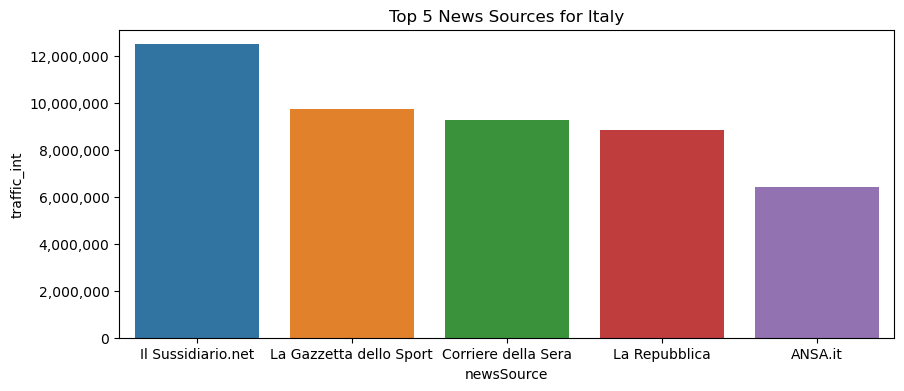

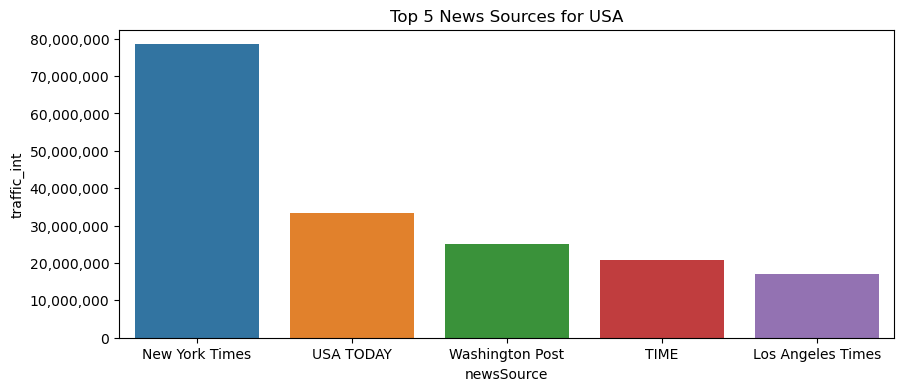

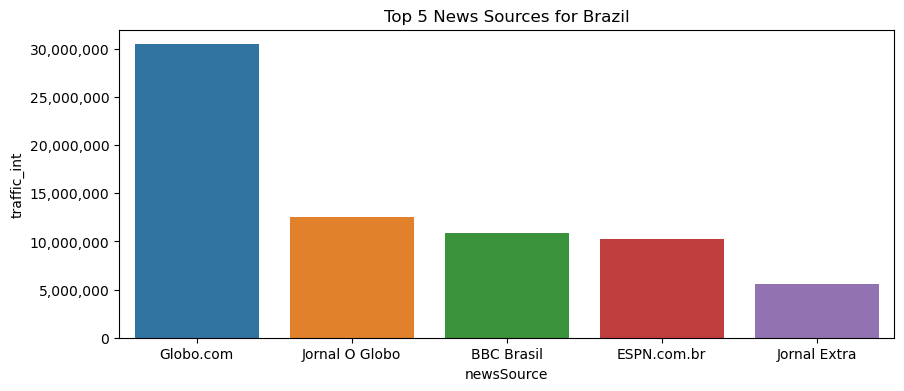

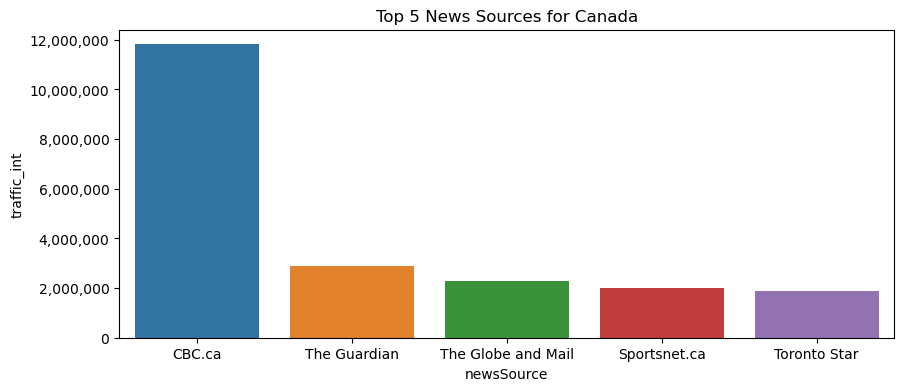

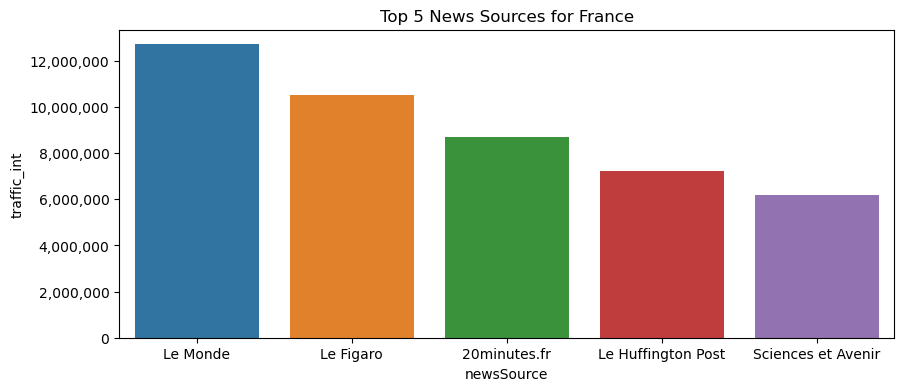

In [54]:
df_top_sources = df.groupby(['country', 'newsSource'], as_index=False)['traffic_int'].sum().sort_values('traffic_int', ascending=False)
list_of_countries = list(df.groupby('country', as_index=False)['name'].count().sort_values('name', ascending=False).head(5).country.unique())
for i in list_of_countries:
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(data=df_top_sources[df_top_sources['country'] == i].head(5), x='newsSource', y='traffic_int')
    plt.title('Top 5 News Sources for '+ i)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.show()

**Besides, let's have a look at most popular News Sources for top 5 languages with most observations in this dataset.**

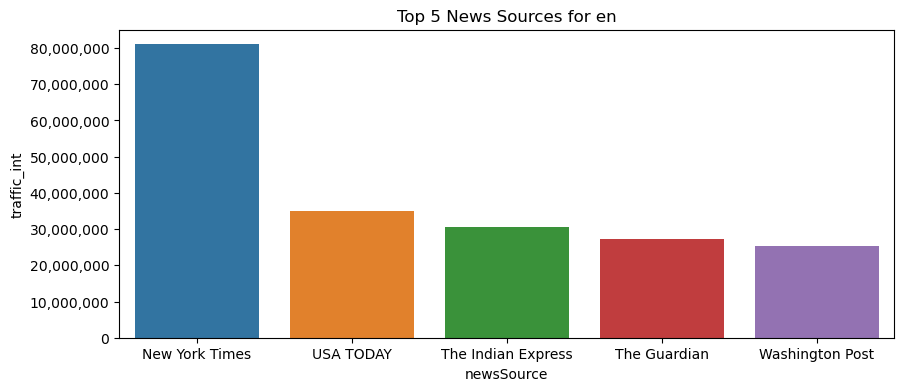

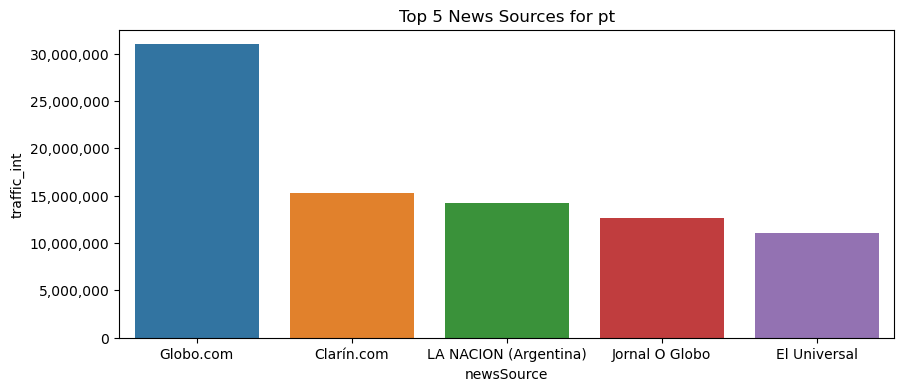

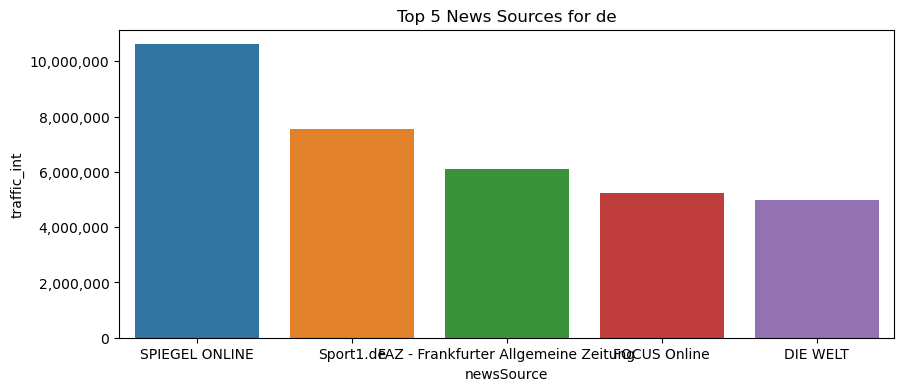

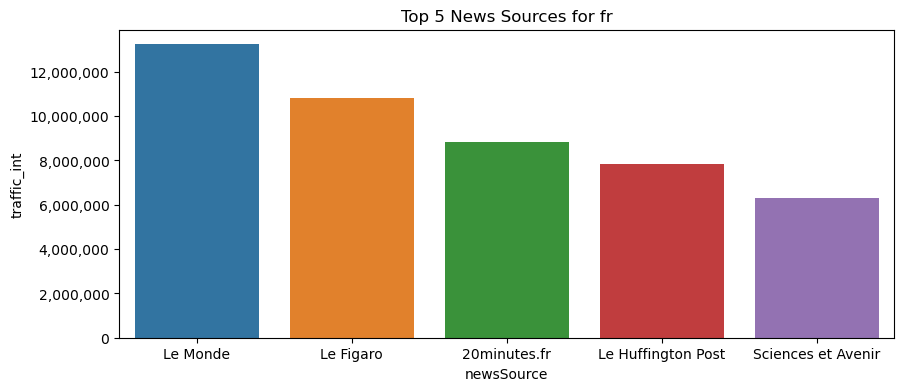

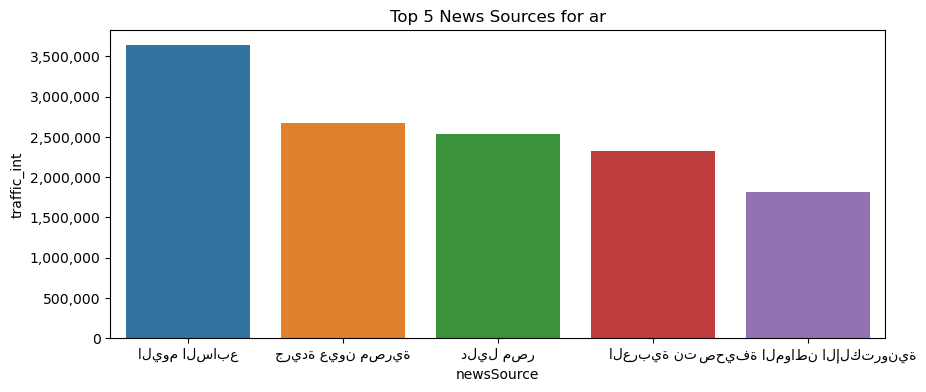

In [55]:
df_top_lang = df.groupby(['language', 'newsSource'], as_index=False)['traffic_int'].sum().sort_values('traffic_int', ascending=False)
list_of_languages = list(df.groupby('language', as_index=False)['name'].count().sort_values('name', ascending=False).head(5).language.unique())
for i in list_of_languages:
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(data=df_top_lang[df_top_lang['language'] == i].head(5), x='newsSource', y='traffic_int')
    plt.title('Top 5 News Sources for '+ i)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.show()

**3. Is there more traffic for pieces of news published on Weekends as opposed to Weekdays?** <a class="anchor" id="eighth-bullet"></a>

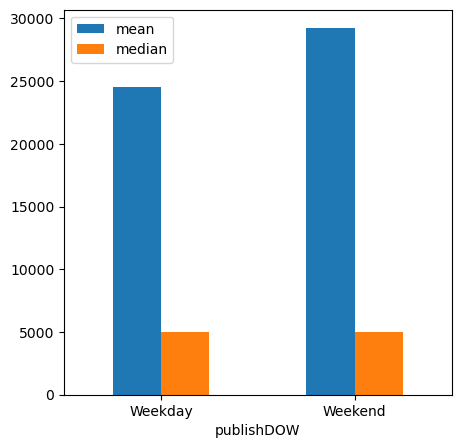

In [56]:
df.groupby(['publishDOW'])['traffic_int'].agg({np.mean, np.median}).plot.bar(figsize=(5, 5))
plt.xticks(rotation=0)
plt.show()

**It is true for the average, but not for the median. It means that there are some ouliers with very high traffic on Weekends (probably some special events that tend to be scheduled on weekends).**

## Data Analysis Using NLP <a class="anchor" id="ninth-bullet"></a>

#### 1. Do the keywords correlate in any way with the traffic? <a class="anchor" id="tenth-bullet"></a>

### WordCloud  <a class="anchor" id="eleventh-bullet"></a>

First of all, let's have a look at the "relatedKeyword" column and create a WordCloud of common keywords for the most represented in this dataset languages.

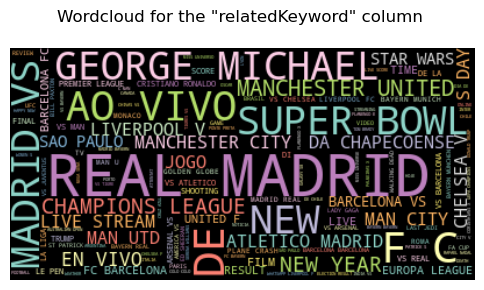

In [57]:
text = ' '.join(df.relatedKeyword[(df.relatedKeyword.notna()) & (df.language.isin(['en', 'es', 'fr', 'pt', 'it', 'de']))])

# Create and generate a word cloud image using collocations (more than 1 word):
wordcloud = WordCloud(collocations=True, max_font_size=50, max_words=150, colormap='Set3').generate(text)

# Display the generated image:
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for the "relatedKeyword" column \n')
plt.show()

There seems to be a clear penchant towards the sports, more precisely, football.

**However, given that about 77% of "relatedKeyword" field is null, and a large part of the rest are unique values, it is difficult to obtain insights from its' analysis. However, the "name" column seems to contain a shorter version of text that looks like keywords, and can be used to our analysis.**

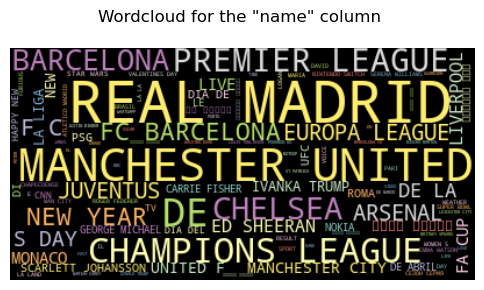

In [58]:
text = ' '.join(df.name)

# Create and generate a word cloud image using collocations (more than 1 word):
wordcloud = WordCloud(collocations=True, max_font_size=50, max_words=150, colormap='Set3').generate(text)

# Display the generated image:
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for the "name" column \n')
plt.show()

**Let's create separate cloud of words based on all text available for each observation for a series of languages separately.**

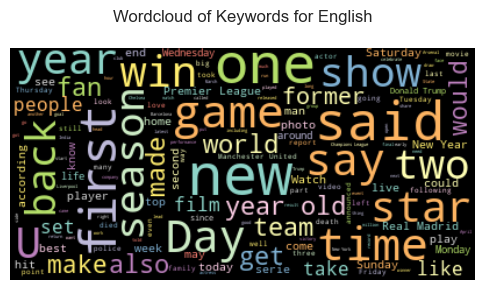

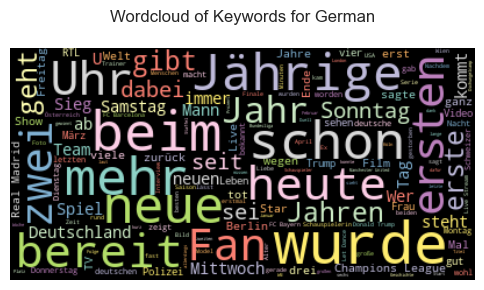

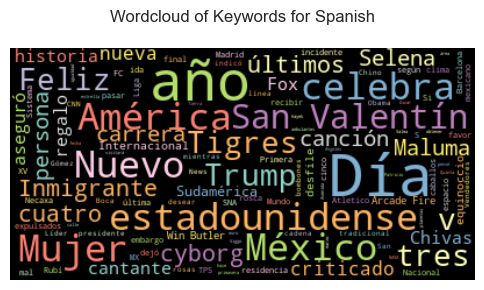

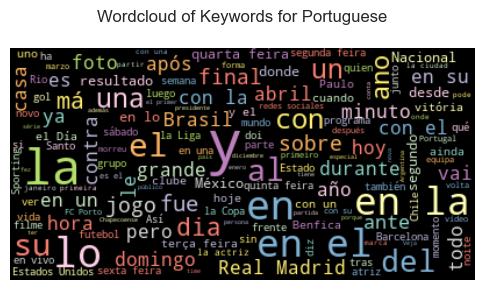

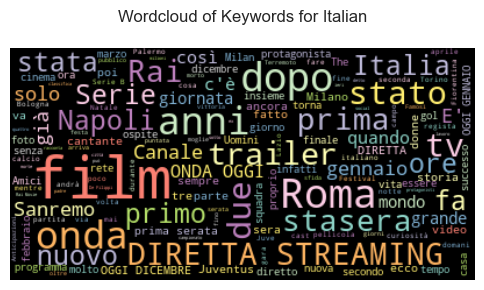

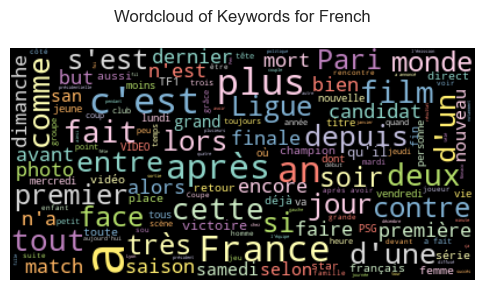

In [153]:
#WordCloud for the most common languages of the dataset
#create a dictionary of some of the languages in the dataset with most traffic
dict_of_languages = {'en': 'english', 'de': 'german','es': 'spanish', 'pt': 'portuguese', 'it': 'italian', 'fr': 'french'}
stop_for_cloud = []
for key, item in dict_of_languages.items():
    text = ' '.join(df.loc[df['language'] == key, 'all_text'])

    #create and generate a word cloud image using corresponding stopword list:
    wordcloud = WordCloud(collocations=True, stopwords=stopwords.words(item), max_font_size=50, max_words=150, colormap='Set3').generate(text)

    #display the generated image:
    plt.figure(figsize=(6,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Wordcloud of Keywords for {item.capitalize()}\n')
    plt.show()

**The result of WordCloud's parsing is not bad, but we still have a lot of just common and even semantically void words, and some keywords that might lose versus others because of duplicates. And it is apparently less informative than the keywords in the "name" column.**

### Bi-grams Extraction with CountVectorizer <a class="anchor" id="twelfth-bullet"></a>

Let's use the "name" column to generate a list of 30 most common 2-grams, using stopword lists from **nltk.corpus module** and **Scikit-learn's CountVectorizer**. This could homogenise some duplicated keywords in this field and give us a more precise result.

In [60]:
#create function to get bi-grams
def get_top_n_bi_grams(corpus, stop_list, n=None):
    '''
    A function that gets n most frequently occuring bi-grams (collocations of 2 words).
    Receives texts, a stop words list and a number of bi-grams as input. Returns a list of bi-grams.
    '''
    vector = CountVectorizer(ngram_range=(2,2),  
            max_features=2000, stop_words=stop_list).fit(corpus)
    bag_of_words = vector.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_of_words[0, idx]) for word, idx in     
                  vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
#create a large stopwords list with languages with most observations in this dataset
stop_list = []  
for value in dict_of_languages.values():
    stop_list = stop_list + stopwords.words(value)
stop_list = set(stop_list)
#get a list of 30 bi-grams for the column "name" and their frequency
top_bi_grams = get_top_n_bi_grams([text for text in df.name.dropna()], stop_list, n=30)
top_df = pd.DataFrame(top_bi_grams)
top_df.columns=["bi_grams", "frequency"]
top_df.head(5)

,bi_grams,frequency
0,real madrid,603
1,manchester united,392
2,champions league,226
3,premier league,219
4,fc barcelona,186


All of these are related to football.

**These are the most frequent keywords in terms of publications. Would the results be the same for the most popular keywords in terms of traffic?**

In [61]:
#create an auxiliary dataset grouping by "name" and calculating sum, median of traffic and count of articles per "name"
df_name_as_keywords = df.groupby(['name'], as_index=False)\
                        .aggregate({'traffic_int': {np.sum, np.median}, 'traffic': 'count'})
df_name_as_keywords.columns = ['name', 'traffic_sum', 'median_traffic', 'articles_total']

In [62]:
#show the keywords with most traffic
df_name_as_keywords.sort_values('traffic_sum', ascending=False).head(5)

,name,traffic_sum,median_traffic,articles_total
19155,NFL PLAYOFFS 2017,5000000.00,5000000,1
1389,ALABAMA VS CLEMSON,5000000.00,5000000,1
28810,WHEN WAS THE FIRST CRICKET TEST MATCH,3000000.00,6000000,2
13203,JAMINI ROY,2500500.00,5001000,2
8004,DÉCOUVERTE D EXOPLANÈTES,2000000.00,2000000,1


In [63]:
#show the keywords with least traffic
df_name_as_keywords.sort_values('traffic_sum', ascending=False).tail(5)

,name,traffic_sum,median_traffic,articles_total
24851,SONIA BRAGA,1000.00,1000,1
1570,ALFRED DORFER,1000.00,1000,1
32697,צ אק ברי,1000.00,1000,1
19784,ODD,1000.00,1000,1
29514,ØYA TV2,1000.00,1000,1


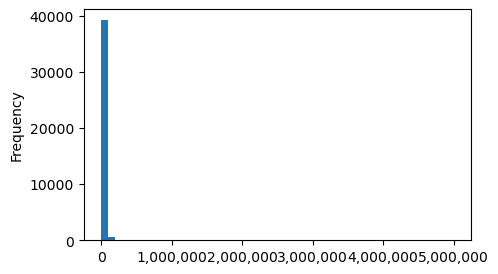

In [64]:
#check the distribution of traffic_sum
df_name_as_keywords.traffic_sum.plot.hist(bins=50, figsize=(5,3))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.show()

In [65]:
#check summary statistics for traffic
df_name_as_keywords.describe()

,traffic_sum,median_traffic,articles_total
count,40001.00,40001.00,40001.00
mean,17836.48,47911.88,1.86
std,78358.11,320469.24,4.82
min,1000.00,1000.00,1.00
25%,2000.00,2000.00,1.00
50%,5000.00,10000.00,1.00
75%,10500.00,20000.00,2.00
max,5000000.00,21202000.00,497.00


**Given the summary statistics, the real difference in traffic is concentrated in the fourth quartile. A closer look at the percentiles might reveal more.**

In [66]:
#check the 25%, 50%, 75%, 80%, 90%, 95%, 97%, 98% and 99% percentiles.
df_name_as_keywords.quantile([0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.97, 0.98, 0.99])

,traffic_sum,median_traffic,articles_total
0.25,2000.00,2000.00,1.00
0.50,5000.00,10000.00,1.00
0.75,10500.00,20000.00,2.00
0.80,20000.00,22000.00,2.00
0.90,26000.00,63000.00,3.00
0.95,50000.00,150000.00,5.00
0.97,100000.00,220000.00,7.00
0.98,101000.00,342000.00,9.00
0.99,200000.00,677000.00,14.00


**Keywords with highest traffic (both sum and median values) are concentrated in the last percentile.**

 ### Top keywords in terms of traffic vs top keywords in terms of frequency <a class="anchor" id="thirteenth-bullet"></a>

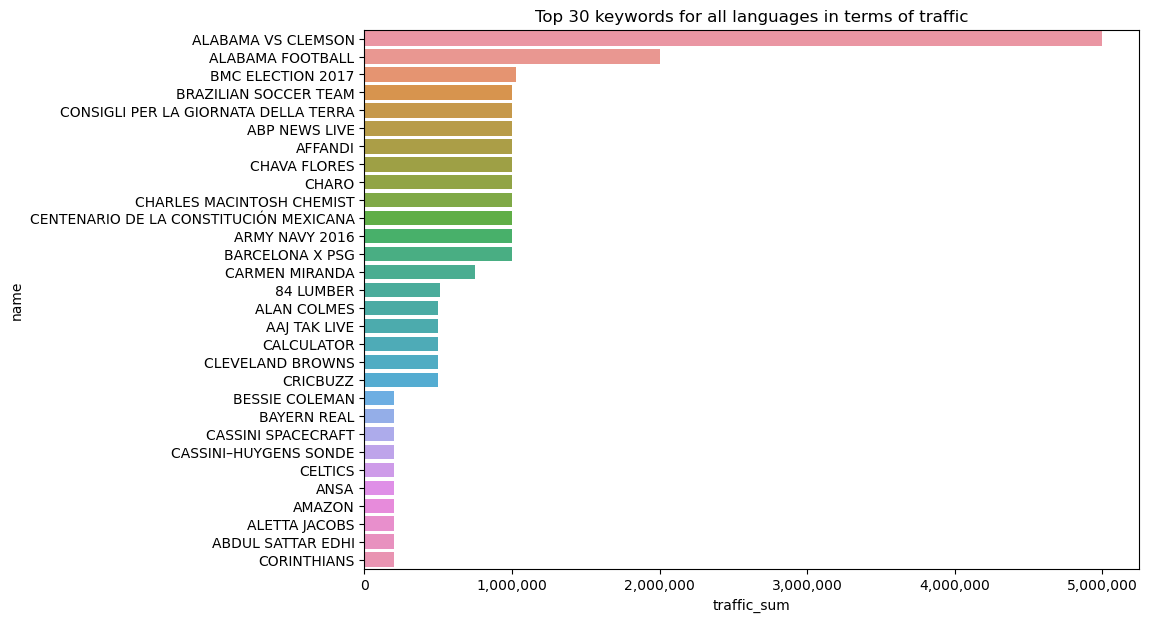

In [67]:
#visualise the keywords with traffic sum 200000+ and median trafic 677000+
df_name_as_keywords_small = df_name_as_keywords.loc[(df_name_as_keywords.traffic_sum >= 200000)\
                                        & (df_name_as_keywords.median_traffic >= 677000),
                                        ['name', 'traffic_sum']].head(30)
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_name_as_keywords_small.sort_values('traffic_sum', ascending=False), y='name', x='traffic_sum')
plt.title('Top 30 keywords for all languages in terms of traffic')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.show()

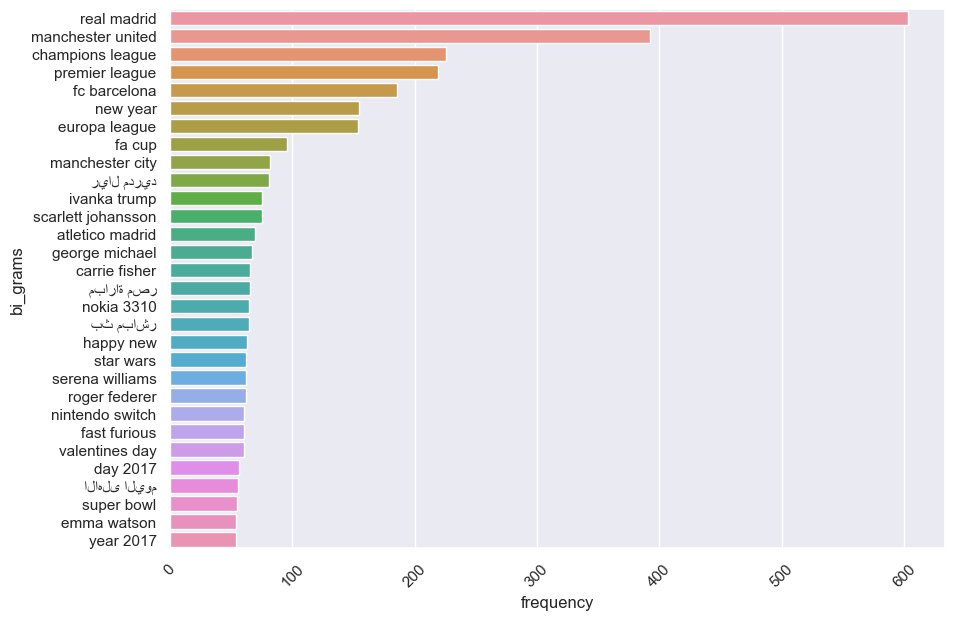

In [68]:
#visualise the most frequent bi-grams in terms of number of publications
sns.set(rc={'figure.figsize':(10,7)})
sns.barplot(y="bi_grams", x="frequency", data=top_df)
plt.xticks(rotation=45)
plt.show()

As we can see, the most frequent keywords and the ones that attract the most traffic are not necessarily the same. However, the football theme is still highly present.

Even with top 30 keywords we can see that the quality of keywords could be better. As we have observed above, there are some duplicates that can't be easily unified because of different level of detail in each keyword like "Alabama Football" and "Alabama vs Clemson", or "new year" and "happy new".

**It is worth a shot to generate a new column with keywords extracted from all text fields of the dataset.**

## Data Prediction

If you're able to create a predective model great. If you have any ideas even if you don't know how to implement it yet let us know what you would do and how

## Keyword extraction with TF IDF <a class="anchor" id="fourteenth-bullet"></a>

#### Given that the keywords in the dataset were mostly missing, or prone to being duplicates, it seems like a good idea to explore more options of extracting keywords.

Tf–idf is often used in information retrieval, text mining and user modeling. Like the CountVectorizer that we have used earlier, this numerical statistic reflects how important a word is to a document in a corpus. However, unlike the Bag of Words method, tf–idf is a bit more sophistacated. The tf–idf value increases for words frequent in this particular text and rare in this corpus in general, which allows to filter out, giving them less weight, words that are frequent in any text in general, but are not in the stop words list.

Functions that will streamline removing punctuation and lemmatizing words:

In [69]:
def strip_punc(string_value):
    '''
    Removes punctuation from the the list of words as well as numbers.
    '''
    str_list = string_value.split()
    punc = string.punctuation + ",.;’_—“”‘"
    new_list = []
    for elem in str_list:
        elem = re.sub(r'\d+', '', elem).strip(punc).strip()
        if elem != "":
            new_list.append(elem)
    return new_list

In [70]:
def lemmatise_and_punc(str_list):
    '''
    Removes punctuation, lemmatizes words and removes stop words.
    Returns a string.
    '''
    final = []
    lemmatizer = WordNetLemmatizer()
    new_list = list(map(str.lower, strip_punc(str_list)))
    for elem in new_list:
        elem = lemmatizer.lemmatize(elem)
        if elem not in stop_list:
            final.append(elem)
    return (' '.join(final))

Function that will get the keywords using the method of term frequency  inverse document frequency, or TF IDF:

In [71]:
def get_tf_idf_keywords(entries, number_of_words, language_specific_stop_list):
    #initialize the vectorizer object with our language-specific stop words list, strip accents and use from 2 to 3-grams
    create_tf_idf = TfidfVectorizer(strip_accents='ascii', ngram_range=(2,3))
    #pass out texts into the vectorizer
    texts_as_tf_idf_vectors = create_tf_idf.fit_transform(lemmatise_and_punc(text) for text in entries)
    #map the words' indexes in the tfidf matrix to the words themselves in a dictionary
    id_to_word = {i: word for i, word in enumerate(create_tf_idf.get_feature_names_out())}
    
    #interate through the matrix and get words with largest tfidf values
    keywords_column = []
    for entry in range(texts_as_tf_idf_vectors.shape[0]):
        #get one entry (it corresponds to a row)
        row_data = texts_as_tf_idf_vectors.getrow(entry)
        #sort all words' indexes in ascending order
        words_in_this_text = row_data.toarray().argsort()
        #get the last words (the ones with largest tfidf values), their number is defined as parameter above
        top_words_for_this_text = words_in_this_text[0, :-1*(number_of_words+1):-1]
        keywords = []
        keywords = [id_to_word[item] for item in top_words_for_this_text]
        keywords_column.append(keywords)
    return keywords_column

Prepare the dataset:

In [72]:
#create a temporary column with all available text
df['all_text'] =  df['name'].str.strip() + ' ' + df['relatedKeyword'].fillna('').str.strip() + ' ' + df['all_text'].fillna('').str.strip()

In [74]:
#generate a list with 1 collocation as keyword per row
keywords_column = get_tf_idf_keywords(df['all_text'], 1, stop_list)

In [75]:
#transform list into a dataframe with one column - "keywords"
df_with_keywords = pd.DataFrame(keywords_column, columns=['keywords'])
df_with_keywords.head(5)

,keywords
0,agustin pappa
1,feriado noviembre
2,gisela berger
3,guillermo salatino
4,leo mayer


In [76]:
#check the structure of the main dataframe
df.head(1)

,year,month_of_year,date,publishDOW,country,language,traffic,traffic_int,name,relatedKeyword,newsTitle,newsSource,newsSnippet,all_text
0,2016,2016-11,2016-11-28,Weekday,Argentina,pt,"2,000+",2000,AGUSTIN PAPPA,NaN,"Así le robaron a Agustín Pappa, el ex particip...",Online-911 (Comunicado de prensa),"La víctima del robo fue Agustín Pappa (20), un...","AGUSTIN PAPPA Así le robaron a Agustín Pappa,..."


In [77]:
#check the new dataframe's dimensions
df_with_keywords.shape

(74222, 1)

In [78]:
#check the main dataframe's dimensions
df.shape

(74222, 14)

In [79]:
#concatenate the resulting dataframe with keywords with the main dataset
df_keywords = pd.concat([df, df_with_keywords], axis=1)
df_keywords.keywords.nunique()

40136

As a result we have 40136 unique values. **Let's visualise the new column and see if these new keywords make any sense.**

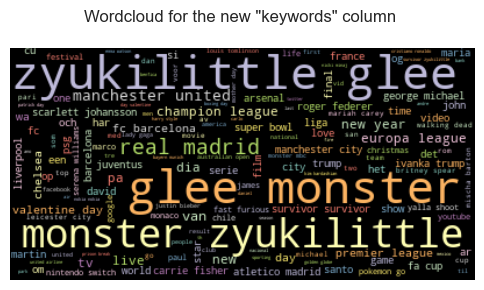

In [83]:
text = ' '.join(df_keywords.keywords.astype('str'))

# Create and generate a word cloud image using collocations (more than 1 word):
wordcloud = WordCloud(collocations=True, max_font_size=50, max_words=150, colormap='Set3').generate(text)

# Display the generated image:
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for the new "keywords" column \n')
plt.show()

## Results of TF IDF, ideas on alternatives <a class="anchor" id="fifteenth-bullet"></a>

The result looks not bad, there are a lot of collocations that we have already seen earlier, but with more words and bi-grams from pop culture and less from sports. However, there are still some common words and some keywords that could be unified further.

**This method normally gives pretty good results, but we have rather small texts in various languages, some of them written in a mix of languages.**

Another approach to this would be to use models like **SpaCy** with pre-trained pipelines. SpaCy is a bit longer to implement and pre-trained pipelines are available only for some 20+ languages, but it would allow us to tackle some of the problems we have seen when using a simple Bag of Words type CountVectorizer and a more sophisticated TF IDF Vectorizer. Namely, SpaCy has Named Entity Recognition that extracts entities from real-world entities like persons, companies and locations. It also has the function of Entity Linking that allows to disambiguate textual entities versus unique identifiers in a knowledge base. For lack of time, I won't try to implement it here.
Besides, given that it is a news dataset, Google's **Word2Vec** model pre-trained on a part of Google News dataset could give good results as well.

## Clustering <a class="anchor" id="sixteenth-bullet"></a>

It would be interesting to cluster these news using text analysis. However, it might be better to do so by language. I will create a subdataset with news (headlines and snippets) in English, vectorize the text field with TF IDF to extract keywords, and apply a **K-Means clustering** to divide these observations in groups by keywords extracted.

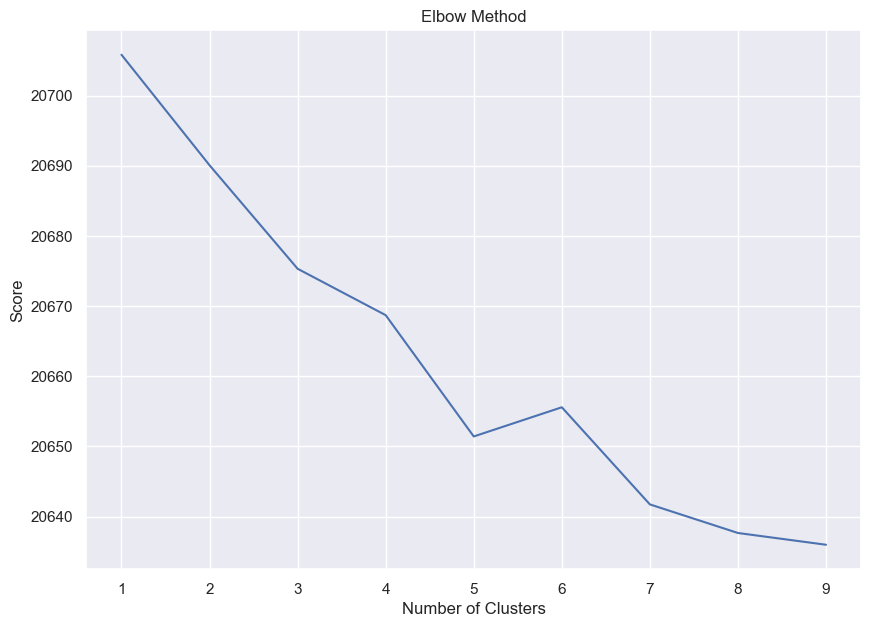

In [130]:
#create a subset of the dataframe with English
df_en = df_keywords[df_keywords['language'] == 'en']

#vectorize the news articles using TF IDF
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii', ngram_range=(2,3) )
X = vectorizer.fit_transform(lemmatise_and_punc(text) for text in df_en['all_text'].astype('str'))

#find the optimal number of clusters with Elbow method

#range of possible clusters that can be generated
number_clusters = range(1, 10) 
#get the number of clusters 
kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

#get score corresponding to each cluster
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
#get the list of positive scores.
score = [i*-1 for i in score]

#visualize Elbow metric
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

*It seems like the best number of clusters would be 5 or 7. Let's try 5.*

In [143]:
#apply K-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

#save the cluster number in a new column
df_en['cluster'] = pd.Series(kmeans.predict(X))

#get 10 top keywords for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
dict_clust = {}
for i in range(5):
    dict_clust[i] = []
    for ind in order_centroids[i, :10]:
        dict_clust[i].append(terms[ind])

In [144]:
#create a new column "cluster keyword" with a string of keywords
for key, value in dict_clust.items():
    df_en.loc[df_en['cluster'] == key, 'cluster_keyword'] = ' '.join(value)

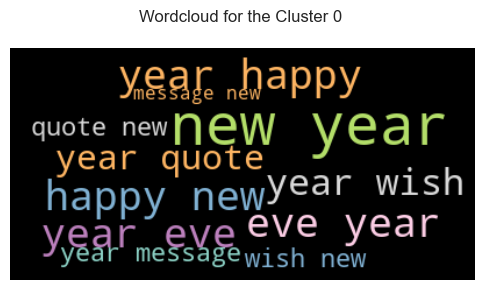

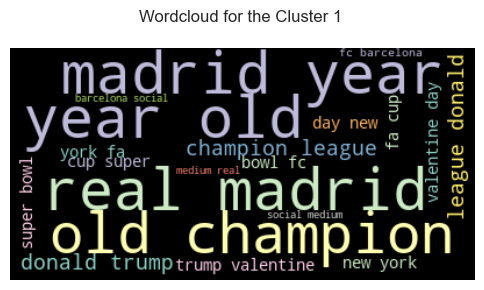

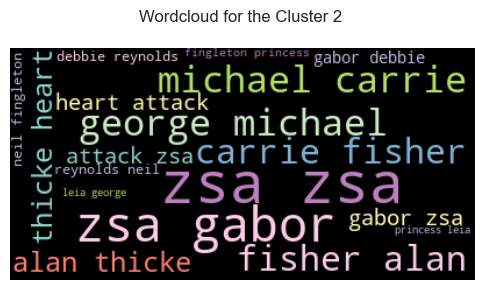

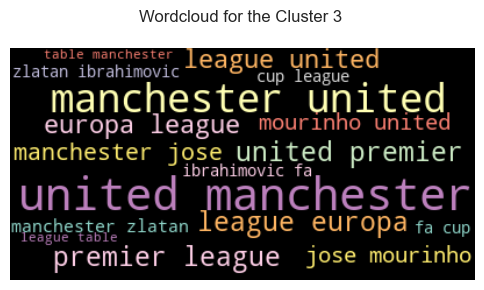

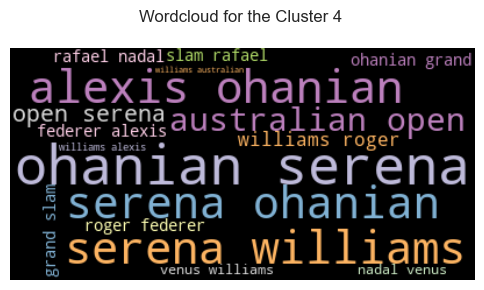

In [145]:
#visualise top keywords by cluster in order to interpret it
for i in range(5):
    text = ' '.join(df_en.loc[df_en['cluster'] == i, 'cluster_keyword'].astype('str').apply(lemmatise_and_punc))

    #create and generate a word cloud image using collocations
    wordcloud = WordCloud(collocations=True, max_font_size=50, max_words=200, colormap='Set3').generate(text)

    #display the generated image
    plt.figure(figsize=(6,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Wordcloud for the Cluster {i} \n')
    plt.show()

**There is some logic to this clusting. We could roughly name the clusters as 'New Year', 'Real Madrid', 'Pop Culture', 'Manchester United', and 'Tennis'. Let's visualise these cluster's traffic over time to see if these fluctuate from month to month.**

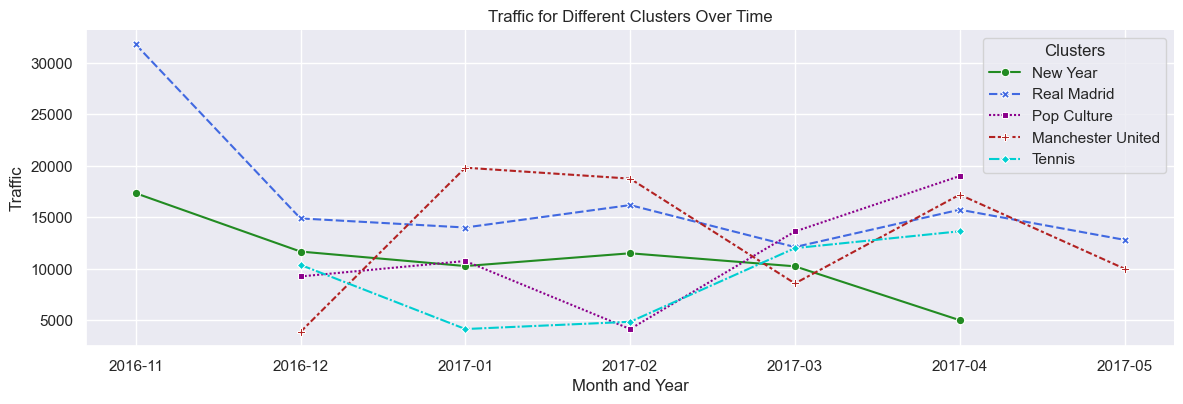

In [147]:
#create a colour palette
colour = {0:'forestgreen',
          1: 'royalblue',
          2: 'darkmagenta',
          3: 'firebrick',
          4: 'darkturquoise',
          5: 'sienna',
          6: 'orange', 
         7: 'slategray'}
#visualise a lineplot
sns.set_style('darkgrid')
sns.relplot(data=df_en, x='month_of_year', y='traffic_int', palette = colour,
            kind='line', style='cluster', hue= 'cluster', markers=True, height=4, aspect=3, ci=None, legend=False)
#create a custom legend
plt.legend(title='Clusters', loc='upper right', labels=['New Year', 'Real Madrid', 'Pop Culture', 'Manchester United', 'Tennis'])
plt.xlabel('Month and Year')
plt.ylabel('Traffic')
plt.title('Traffic for Different Clusters Over Time')
plt.show()

## Further ideas on models <a class="anchor" id="seventeenth-bullet"></a>

I have tried only **K-means** clustering method, which is one that comes to mind first. It did reveal some similarities, but the clusters could be improved. On one hand, this could be done by finetuning the keyword extraction, and parameters of the method. On the other hand, another method might result more accurate. For example, another vector based clustering method worth trying with text is **DBSCAN**. Another idea would be to do topic modeling to discover themes in these texts with **Latent Dirichlet allocation, or LDA.**